# 배경정의


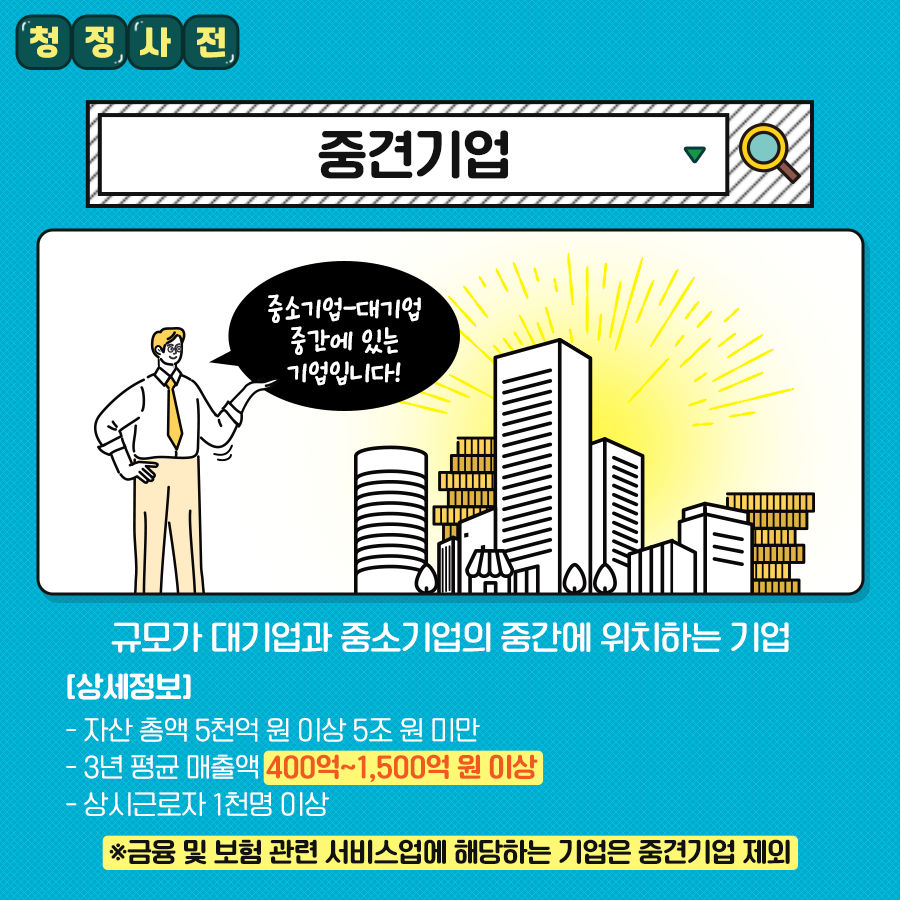

### **데이터 전처리 과정**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import kstest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 이곳에 코드를 작성하세요.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vgames2.csv')


#### **각 데이터프레임의 결측 데이터를 확인.**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [ ]:
# 이곳에 코드를 작성하세요.
df.isnull().sum()

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

결측치를 가진 데이터가 대략 2% 정도의 비율을 가지고 있다. 10% 아래이기 때문에, 모든 결측치를 가진 행을 제거하는 것이 효율적인 데이터 분석에 도움이 된다고 판단한다.

결측치를 대체하는 방법도 있으나, 나머지 데이터와의 통일성을 위해서 결측치 제거가 더 합리적이라고 생각했다

In [ ]:
df = df.dropna(subset=['Year','Genre','Publisher'])
df.drop('Unnamed: 0', axis=1, inplace=True)
df.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


출고량의 자료형이 object이므로, float으로 바꿔준다.


기본 단위는 출고량을 조사했을 때, 백만 단위라고 생각된다.

각각의 출고량은 K나 M을 통한 단위 표현과 그냥 숫자만으로 이루어진 단위 표현이 섞여있으므로 데이터 분석을 위해서 float 자료형으로 모두 변환한다.


In [ ]:
def KM_change(df, col):
  K = df[df[col].str.contains('K')][col].str.replace('K', '', regex=True).astype(float)
  M = df[df[col].str.contains('M')][col].str.replace('M', '', regex=True).astype(float)
  df[col] = df[col].str.replace('[a-zA-Z]', '', regex=True).astype(float) * 1000000
  df.loc[K.index ,col] = K * 1000
  df.loc[M.index ,col] = M * 1000000
  df[col].astype(int)
  return df

In [ ]:
KM_change(df, 'NA_Sales')
KM_change(df, 'EU_Sales')
KM_change(df, 'JP_Sales')
KM_change(df, 'Other_Sales')

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40000.0,0.0,0.0,0.0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170000.0,0.0,0.0,10000.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.0,0.0,20000.0,0.0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40000.0,0.0,0.0,0.0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120000.0,90000.0,0.0,40000.0
...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,150000.0,40000.0,0.0,10000.0
16237,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,10000.0,0.0,0.0,0.0
16238,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,440000.0,190000.0,30000.0,130000.0
16239,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,50000.0,50000.0,250000.0,30000.0


Platform 칼럼에서 PC를 제외한 모든 범주는 콘솔 게임기에 해당한다.

따라서 데이터 분석에 편의성을 위해 PC 아니면 Console으로 바꿔주도록 한다.

In [ ]:
df['Platform'] = df['Platform'].replace('^((?!PC).)*$', 'Console', regex=True)

#### **데이터프레임의 중복 데이터를 확인.**

In [ ]:
# 이곳에 코드를 작성하세요.
df.duplicated().sum()

71

중복값은 0

또한 전체 판매량이 없으므로, 새로운 칼럼을 생성해준다.

In [ ]:
df['All_Sales'] = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum(axis=1)

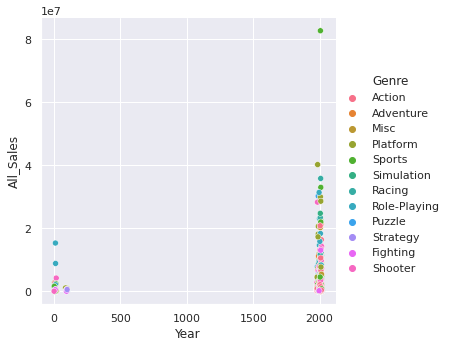

In [ ]:
# 이곳에 코드를 작성하세요.
geo_u_c = df.loc[df['Genre'].str.contains('usa|chn')]

sns.relplot(data=df, x='Year', y='All_Sales', hue='Genre')


년도별 총 판매량에서 이상치가 보인다

Point Blank 3 는 2000년대 게임인데 0으로 표기되고 있다. 즉, 1900년이나 2000년의 표기가 빠져있는 것이다.



In [ ]:
y1 = df.query('Year <= 22')['Year'] + 2000
df.loc[y1.index, 'Year'] = y1
y2 = df.query('Year < 100')['Year'] + 1900
df.loc[y2.index, 'Year'] = y2
df['Year'] = df['Year'].astype(int)

df['Year']

0        2008
1        2009
2        2010
3        2010
4        2010
         ... 
16236    2006
16237    2005
16238    2015
16239    2013
16240    1996
Name: Year, Length: 16241, dtype: int64

다음 분기에 설계할 게임에 대해서 데이터 분석을 하기 위해서는 게임 장르에 대한 선호도와 트렌드가 어떻게 관계가 있는지 알아볼 필요가 있다.

선호도와 트렌드가 모두 관계가 있다면, 높은 선호도와 최신 트렌드를 가진 게임일수록 합리적인 선택이 될 것이라고 생각한다.

# **Q1. 지역에 따라서 선호하는 게임 장르가 다를까**


고객층을 한국 시장으로 계획하고 있기에, 지역에 따라서 게임 장르가 다르다면 한국 시장만의 전략을 수립할 필요가 있다.

## 데이터 준비

In [ ]:
g = df.groupby('Genre', as_index=False)

In [ ]:
g.mean()

,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
0,Action,2007.906481,265046.296296,158530.864198,48333.333333,56787.037037,528697.530864
1,Adventure,2008.126183,80276.025237,50205.047319,40906.940063,13170.347003,184558.359621
2,Fighting,2004.622754,263892.215569,119640.718563,104359.281437,43293.413174,531185.628743
3,Misc,2007.301011,234818.560381,123825.104105,61975.014872,43212.373587,463831.052945
4,Platform,2003.804124,510171.821306,229816.723940,149518.900344,58934.707904,948442.153494
5,Puzzle,2005.227915,214805.653710,89169.611307,99363.957597,21978.798587,425318.021201
6,Racing,2004.841674,290976.210008,192797.374897,46201.804758,62764.561116,592739.950779
7,Role-Playing,2007.057338,217583.617747,124976.109215,234081.911263,38723.549488,615365.187713
8,Shooter,2005.921094,448812.500000,242367.187500,29828.125000,79578.125000,800585.937500
9,Simulation,2006.548463,214456.264775,133557.919622,75106.382979,37021.276596,460141.843972


## 결과

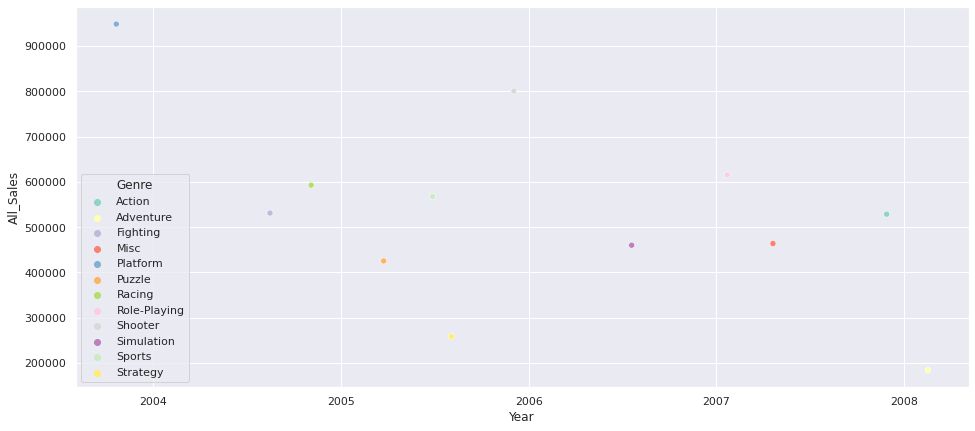

In [ ]:
sns.set(rc = {'figure.figsize':(16,7)})
sns.scatterplot(data=g.mean(), x='Year', y='All_Sales', hue='Genre', palette = 'Set3')

평균적으로 최근에 출시되는 게임 장르는 [Adventure, Action, Misc] 이고
가장 판매량이 높았던 게임 장르는 [Platform, Shooter, Role-Playing] 이다.

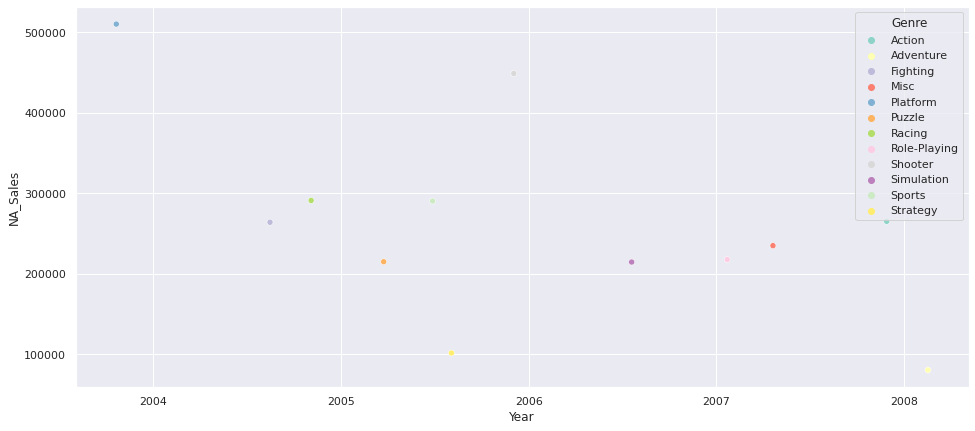

In [ ]:
sns.set(rc = {'figure.figsize':(16,7)})
sns.scatterplot(data=g.mean(), x='Year', y='NA_Sales', hue='Genre', palette = 'Set3')

NA 지역의 판매량 순위는 [Platform, Shooter, Racing, Sports]

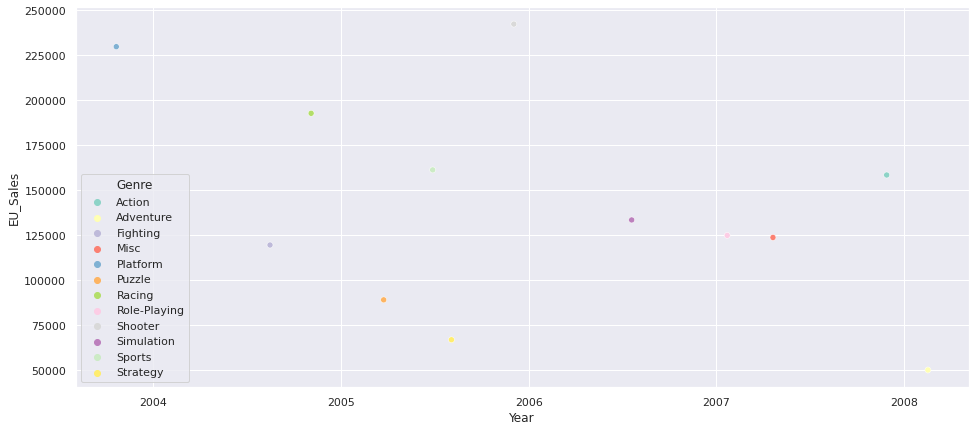

In [ ]:
sns.set(rc = {'figure.figsize':(16,7)})
sns.scatterplot(data=g.mean(), x='Year', y='EU_Sales', hue='Genre' , palette = 'Set3')

EU 지역의 판매량 순위는 [Shooter, Platform, Racing]



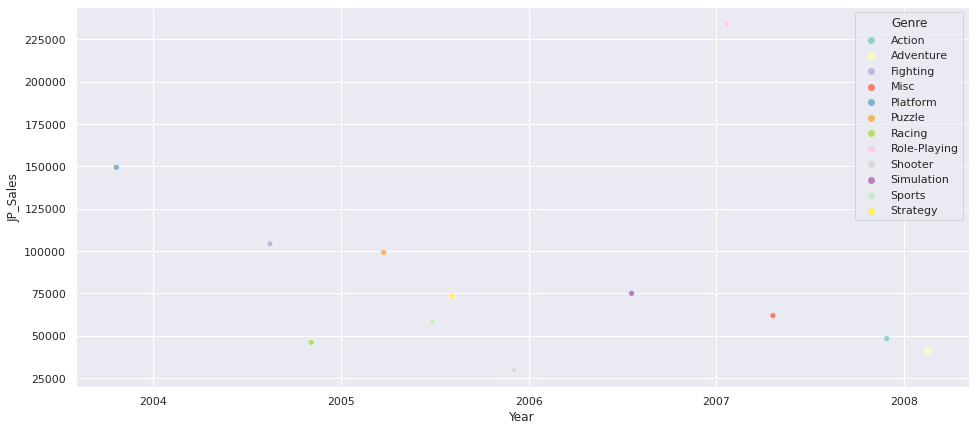

In [ ]:
sns.scatterplot(data=g.mean(), x='Year', y='JP_Sales', hue='Genre', palette = 'Set3')

JP 지역의 판매량 순위는 [Role-Playing, Platform, Fighting]

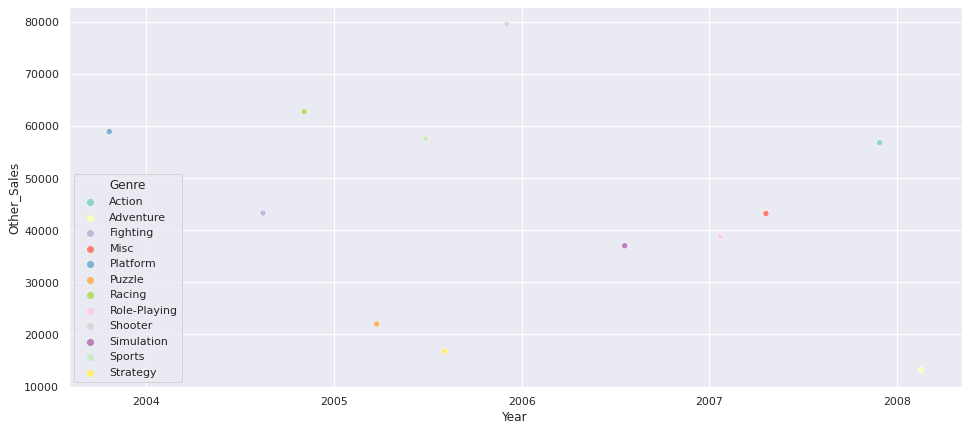

In [ ]:
sns.scatterplot(data=g.mean(), x='Year', y='Other_Sales', hue='Genre', palette = 'Set3')

Other 지역의 판매량은 [Shooter, Racing, Platform]

직관적으로 봐도 각 지역마다 선호하는 게임 장르가 다른 것으로 보인다.
따라서 통계적으로 유의미한 정보를 얻기 위해서 검정법을 진행하는 것이 좋다고 판단한다

지역별 출고량이 장르와 연관이 있는지에 대해서 알아보기 위해서 ANOVA 검정법을 사용한다.

ANOVA 검정법은 독립 변수가 종속 변수에 영향을 끼치는지 알아볼 때 사용합니다.

#ANOVA 검정

##데이터 준비

In [ ]:
sales = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Genre']]

In [ ]:
sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Genre
0,40000.0,0.0,0.0,0.0,Action
1,170000.0,0.0,0.0,10000.0,Action
2,0.0,0.0,20000.0,0.0,Adventure
3,40000.0,0.0,0.0,0.0,Misc
4,120000.0,90000.0,0.0,40000.0,Platform
...,...,...,...,...,...
16236,150000.0,40000.0,0.0,10000.0,Platform
16237,10000.0,0.0,0.0,0.0,Action
16238,440000.0,190000.0,30000.0,130000.0,Sports
16239,50000.0,50000.0,250000.0,30000.0,Action


In [ ]:
sales.corr()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
NA_Sales,1.000000,0.768906,0.449358,0.634707
EU_Sales,0.768906,1.000000,0.432350,0.728084
JP_Sales,0.449358,0.432350,1.000000,0.285395
Other_Sales,0.634707,0.728084,0.285395,1.000000


##결과

In [ ]:
model = ols('NA_Sales ~ C(Genre)', data=sales).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),11.0,1.675983e+14,1.523621e+13,22.859221,3.400631e-47
Residual,16229.0,1.081701e+16,6.665237e+11,NaN,NaN


PR값이 0.05 미만이 나올 경우 해당 지역의 출고량은 게임 장르와 연관이 있다는 의미이다. 그리고 PR값이 0에 가깝게 나왔으니 연관이 있다는 가설이 채택된다.

In [ ]:
model = ols('EU_Sales ~ C(Genre)', data=sales).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),11.0,4.153493e+13,3.775903e+12,14.748175,6.682042e-29
Residual,16229.0,4.155031e+15,2.560251e+11,NaN,NaN


In [ ]:
model = ols('JP_Sales ~ C(Genre)', data=sales).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),11.0,5.110800e+13,4.646182e+12,50.193819,2.034770e-109
Residual,16229.0,1.502234e+15,9.256482e+10,NaN,NaN


In [ ]:
model = ols('Other_Sales ~ C(Genre)', data=sales).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),11.0,4.964596e+12,4.513269e+11,12.643548,3.249514e-24
Residual,16229.0,5.793140e+14,3.569622e+10,NaN,NaN


다른 지역에서도 똑같이 게임 장르가 지역의 출고량에 영향을 준다는 가설이 채택된다.

ANOVA 검정에 의해서, 각 지역 출고량은 장르에 따라서 영향을 받는다는 대립가설이 채택된다.

또한 해당 지역에서 장르마다 판매량의 차이를 알아보려면 이원 카이제곱 검정을 사용할 수 있다.

카이제곱 검정은 범주형 자료(이 경우엔 "장르")를 대상으로 한 가설의 검정에 사용된다.

#카이제곱 검정

## 데이터 준비

In [ ]:

scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(sales)
s = scaler.transform(sales)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_df = pd.DataFrame(data=s, columns=sales.columns)

In [ ]:
s_df['Genre'] = df['Genre']
s_df['Year'] = df['Year']

In [ ]:
na_table

NA_Sales,-0.322513,-0.310341,-0.298169,-0.285997,-0.273825,-0.261653,-0.249481,-0.237309,-0.225137,-0.212965,...,15.233231,16.754724,17.436352,17.898886,18.848298,18.970017,27.916396,32.456530,35.073498,50.178880
Genre,,,,,,,,,,,,,,,,,,,,,
Action,725,82,106,110,103,100,78,88,92,85,...,0,0,0,0,0,0,0,0,0,0
Adventure,733,33,31,38,27,33,33,38,31,20,...,0,0,0,0,0,0,0,0,0,0
Fighting,251,21,16,27,23,27,30,17,14,23,...,0,0,0,0,0,0,0,0,0,0
Misc,522,47,33,41,49,46,45,47,53,44,...,0,1,0,1,0,0,0,0,0,0
Platform,84,28,36,28,31,36,27,24,23,24,...,1,0,1,0,0,0,0,0,1,0
Puzzle,132,39,38,30,30,28,20,27,14,11,...,0,0,0,0,0,0,1,0,0,0
Racing,138,62,55,67,49,45,52,51,40,44,...,0,0,0,0,0,1,0,0,0,0
Role-Playing,618,31,37,33,39,36,42,47,36,32,...,0,0,0,0,0,0,0,0,0,0
Shooter,159,57,51,52,50,49,46,38,35,30,...,0,0,0,0,0,0,0,1,0,0


## 결과

In [ ]:
na_table = pd.crosstab(index = s_df['Genre'], columns = s_df['NA_Sales'])

chi, p, _, _ = stats.chi2_contingency(na_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 6233.655354090705
p-value : 7.549444125974192e-63


카이제곱 검정을 통해서 "장르와 NA 지역 판매량은 관계가 없다" 라는 귀무가설은 p-value < 0.05 으로 기각된다.

즉, 대립가설인 "장르와 NA 지역 판매량은 관계가 있다." 를 채택한다.

In [ ]:
eu_table = pd.crosstab(index = s_df['Genre'], columns = s_df['EU_Sales'])

chi, p, _, _ = stats.chi2_contingency(eu_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 4477.935832640966
p-value : 6.8167487877648e-38


EU 지역에서도 같은 결과

In [ ]:
jp_table = pd.crosstab(index = s_df['Genre'], columns = s_df['JP_Sales'])

chi, p, _, _ = stats.chi2_contingency(jp_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 5219.175760673923
p-value : 5.08736657649697e-172


JP 지역에서도 같은 결과

In [ ]:
other_table = pd.crosstab(index = s_df['Genre'], columns = s_df['Other_Sales'])

chi, p, _, _ = stats.chi2_contingency(other_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 2285.5343815803913
p-value : 1.0672942341351104e-19


Other 지역에서도 같은 결과

결론적으로 모든 지역에서 장르에 따른 출고량의 차이가 있다.

카사바나와 스미스의 "메뉴 엔지니어링" 에 따르면 선호도 = 판매량으로 간주할 수 있으며 이를 적용한다면 지역마다 게임 장르의 선호도 차이가 있다고 생각할 수 있다.

메뉴 엔지니어링을 활용하여 최신 트렌드와 선호도롤 토대로 4분위로 게임 장르를 나눠본다.

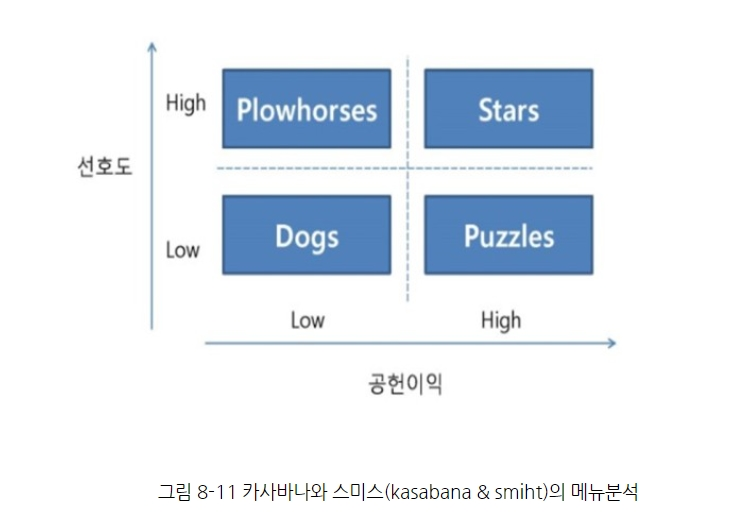

트렌드와 선호도의 그래프에서도, 최신 트렌드와 가장 높은 선호도를 가진 장르가 우측 위에 자리잡을 것이고 위 그림처럼 Stars의 위치일 것이다.

# **Q2.연도별 게임의 트렌드가 있을까**

위에서 지역간의 선호도 차이와 선호도와 장르 간의 차이가 존재함을 알았다.

이에 따라서 게임의 트렌드, 출시년도와 장르 간의 상관관계가 있는지 확인해볼 것이다.

도메인지식으로 보았을 때, 게임 트렌드의 차이는 존재할 것이라는 가설에 무게감이 실린다. 과거 테트리스에서 현재 마인크래프트까지 상당히 바뀐 것이 사실이니까 말이다.



# 히트맵

## 데이터 준비

In [ ]:
df_year = df.groupby(['Genre']).mean()

df_year

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
Genre,,,,,,
Action,2007.906481,265046.296296,158530.864198,48333.333333,56787.037037,528697.530864
Adventure,2008.126183,80276.025237,50205.047319,40906.940063,13170.347003,184558.359621
Fighting,2004.622754,263892.215569,119640.718563,104359.281437,43293.413174,531185.628743
Misc,2007.301011,234818.560381,123825.104105,61975.014872,43212.373587,463831.052945
Platform,2003.804124,510171.821306,229816.723940,149518.900344,58934.707904,948442.153494
Puzzle,2005.227915,214805.653710,89169.611307,99363.957597,21978.798587,425318.021201
Racing,2004.841674,290976.210008,192797.374897,46201.804758,62764.561116,592739.950779
Role-Playing,2007.057338,217583.617747,124976.109215,234081.911263,38723.549488,615365.187713
Shooter,2005.921094,448812.500000,242367.187500,29828.125000,79578.125000,800585.937500


In [ ]:
y_table = pd.crosstab(index = s_df['Genre'], columns = s_df['Year'])
y_table

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020
Genre,,,,,,,,,,,,,,,,,,,,,
Action,1,25,18,7,1,2,6,2,2,2,...,271,226,239,264,148,186,253,119,1,0
Adventure,0,0,0,1,0,0,0,1,0,0,...,141,153,107,57,60,75,53,34,0,0
Fighting,1,0,0,0,0,1,0,2,0,0,...,53,40,49,29,20,23,21,14,0,0
Misc,4,0,1,1,1,0,0,0,0,1,...,207,200,183,38,42,41,39,18,0,0
Platform,0,3,5,5,1,4,6,2,4,3,...,28,31,37,12,37,10,14,10,0,0
Puzzle,0,2,3,1,3,4,0,0,1,5,...,79,45,43,11,3,8,6,0,0,0
Racing,0,1,2,0,3,0,1,0,1,0,...,83,57,65,30,16,27,19,20,0,0
Role-Playing,0,0,0,0,0,0,1,3,3,2,...,103,103,95,78,70,91,78,40,2,0
Shooter,2,10,5,1,3,1,4,2,1,1,...,91,81,94,48,59,47,34,32,0,0


## 결과

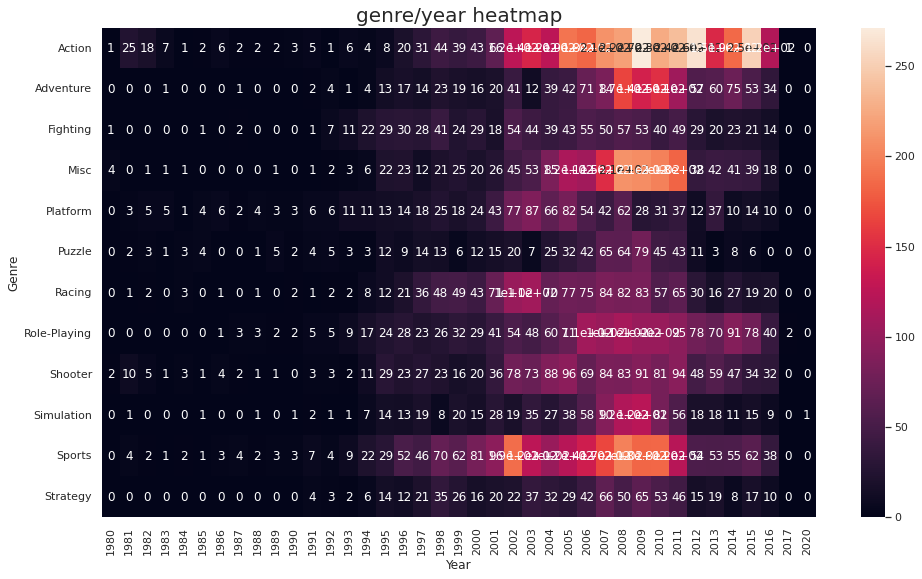

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.heatmap(y_table, annot=True)
plt.title('genre/year heatmap', fontsize=20)
plt.show()

밝게 빛나는 부분일수록 해당 출시년도에 많이 출시된 장르라는 의미다.

특정 부분만 밝다는 점을 봐서, 직관적으로도 게임에 트렌드가 존재한다고 볼 수 있다

대략 2002년부터 2016년까지는 Action 장르의 게임이 다수 출시되었으며 2017년 이후의 데이터가 부족하지만 현재까지도 Action 장르의 트렌드가 유지된다고 생각할 수 있다.

In [ ]:
chi, p, _, _ = stats.chi2_contingency(y_table)
print('chi :', chi)   
print('p-value :', p) 

chi : 2762.7998731892867
p-value : 0.0


이원 카이제곱 검정에 의해서 p값이 0.05 미만이므로 귀무가설이 기각된다.

즉, "장르와 출시년도 사이에는 관계가 있다." 라고 볼 수 있다.

결론적으로 장르는 선호도와의 관계가 있으며, 출시년도와도 관계가 있다.

즉, 트렌드와 선호도를 토대로 다음 분기에 설계할 게임 장르를 선택한다는 가정은 설득력을 가진다.

# Q.트렌드와 선호도는 관계가 있는가?

이제 알아볼 부분은 "트렌드와 선호도는 관계가 있는가?" 에 대한 부분이다.

이는 최신 트렌드라고 명백히 파악되는 [Action] 장르의 평균적인 출고량이 양의 상관관계를 가지는지 확인해야 한다.


## 데이터 준비

In [ ]:
sales = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','All_Sales']]
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(sales)
s = scaler.transform(sales)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_df = pd.DataFrame(data=s, columns=sales.columns)
s_df['Genre'] = df['Genre']
s_df['Year'] = df['Year']

In [ ]:
s_df[s_df['Year'] > 2015][s_df['Genre'] == 'Action']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales,Genre,Year
218,-0.298144,-0.171895,-0.220792,-0.148857,-0.274380,Action,2016
332,-0.322463,-0.289930,-0.220792,-0.254302,-0.338324,Action,2016
416,-0.322463,-0.289930,-0.220792,-0.254302,-0.338324,Action,2016
722,0.261191,0.300245,0.005553,0.167478,0.256359,Action,2016
913,-0.322463,-0.211240,-0.253127,-0.201580,-0.312746,Action,2016
...,...,...,...,...,...,...,...
15662,-0.310304,-0.270257,-0.253127,-0.254302,-0.331930,Action,2016
15779,-0.322463,-0.289930,-0.188457,-0.254302,-0.331930,Action,2016
15983,-0.322463,-0.270257,-0.253127,-0.254302,-0.338324,Action,2016
16084,0.394945,1.992079,-0.059117,1.485542,1.023693,Action,2016


In [ ]:
y_table = pd.crosstab(index = s_df['Genre'], columns = s_df['Year'])

In [ ]:
s_df[s_df['Genre'] == 'Action'].groupby('Year').mean()['All_Sales']

Year
1980   -0.127307
1981    0.033577
1982   -0.113808
1983   -0.083460
1984    0.838254
1985    0.780704
1986    1.119610
1987    0.010173
1988    0.211598
1989    1.141991
1990    1.017299
1991    0.519811
1992    2.110749
1993   -0.151819
1994   -0.096934
1995   -0.058567
1996    0.313909
1997    0.224387
1998    0.228020
1999    0.108139
2000    0.159253
2001    0.204429
2002    0.098544
2003   -0.042847
2004    0.044831
2005   -0.059899
2006   -0.113650
2007   -0.021982
2008    0.050803
2009   -0.018342
2010   -0.012264
2011   -0.026334
2012   -0.051060
2013    0.196260
2014   -0.004335
2015   -0.172220
2016   -0.237205
2017   -0.338324
Name: All_Sales, dtype: float64

In [ ]:
new_df = pd.concat([s_df[s_df['Genre'] == 'Action'].groupby('Year').mean()['All_Sales'], y_table.loc['Action']], axis=1)
new_df = new_df.drop(2020)
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(new_df)
s = scaler.transform(new_df)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_new = pd.DataFrame(data=s, columns=new_df.columns)
s_new.index = new_df.index

## 결과

Action 장르와 총 출고량의 관계를 나타낸 그래프

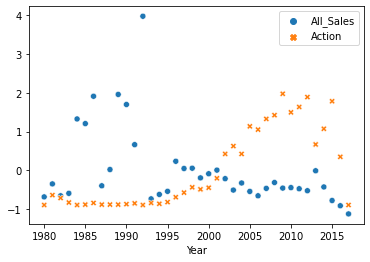

In [ ]:
sns.scatterplot(data = s_new)

In [ ]:
new_df = pd.concat([s_df[s_df['Genre'] == 'Role-Playing'].groupby('Year').mean()['All_Sales'], y_table.loc['Role-Playing']], axis=1)
new_df = new_df.drop(2020)
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(new_df)
s = scaler.transform(new_df)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_new = pd.DataFrame(data=s, columns=new_df.columns)
s_new.index = new_df.index

Role-Playing 장르와의 관계를 나타낸 그래프

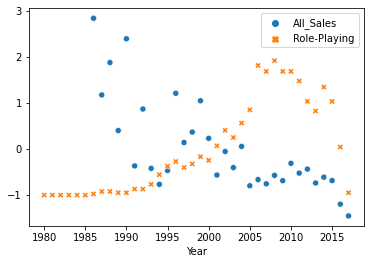

In [ ]:
sns.scatterplot(data = s_new)

In [ ]:
new_df = pd.concat([s_df[s_df['Genre'] == 'Shooter'].groupby('Year').mean()['All_Sales'], y_table.loc['Shooter']], axis=1)
new_df = new_df.drop(2020)
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(new_df)
s = scaler.transform(new_df)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_new = pd.DataFrame(data=s, columns=new_df.columns)
s_new.index = new_df.index

Shooter 장르와의 관계를 나타낸 그래프

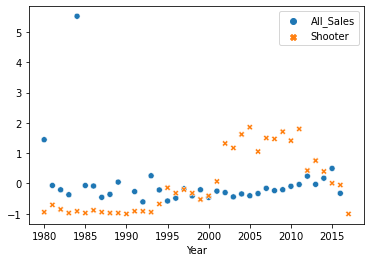

In [ ]:
sns.scatterplot(data = s_new)

In [ ]:
s_new.corr()

,All_Sales,Shooter
All_Sales,1.00000,-0.19777
Shooter,-0.19777,1.00000


선호도와 트렌드 사이에는 유의미한 수준의 상관관계가 존재하지 않는다.

즉, 게임 장르에는 트렌드가 존재하지만, 그런 경향이 선호도로 이어진다고 보기는 힘들다.

이에 따라서 트렌드를 생각하지 않고 장르를 선택하는 것이 합리적이라고 판단할 수 있다.

과연 이게 옳은 생각일까?

트렌드(Trend)의 사전적 의미는 어떤 방향으로 쏠리는 현상, 경향, 동향, 추세, 스타일을 뜻한다. 무언가를 다르거나 새롭게 변화, 발전시키는 것을 의미한다. 트렌드는  생성, 성장, 정체, 후퇴 등 변동 경향을 나타내는 움직임으로 시대정신과 가치관이 반영된다.

출처 : 감탄시대(http://www.gamtantimes.com)

- 결국 트렌드 라는 개념은 하나의 장르로 묶여지는 것이 아니라 다양한 장르 속에서 트렌드를 형성할 수도 있으며 이에 따라서 장르별 선호도에 대한 상관관계로는 분석하기 힘든 부분이 있다.

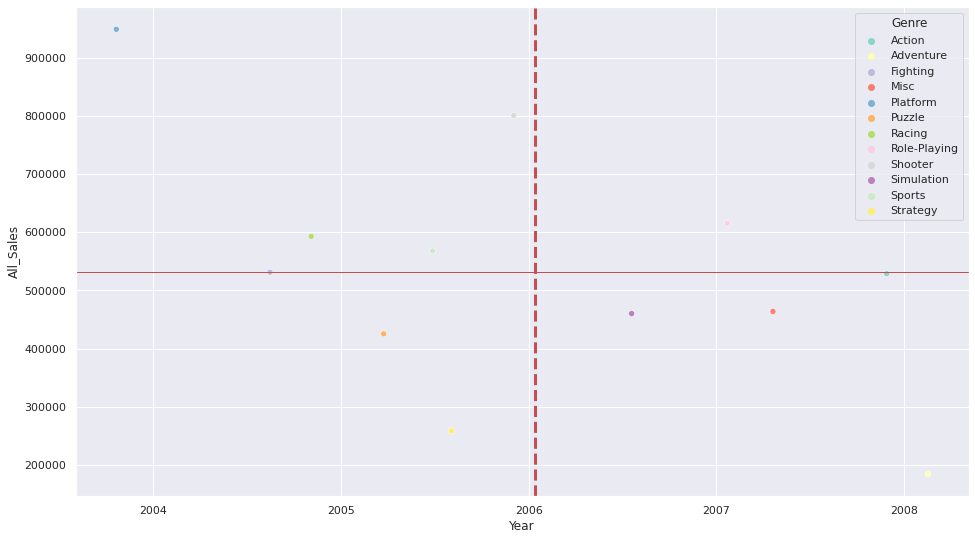

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(data=df_year, x='Year', y='All_Sales', hue='Genre', palette = 'Set3')
plt.axhline(y=df_year['All_Sales'].mean(), color='r', linewidth=1)
plt.axvline(x=df_year['Year'].mean(), color='r', linestyle='--', linewidth=3)

판매량(선호도)와 최근의 트렌드를 고려했을 때, 좌측 상단의 Platform은 고수익이나 트렌드에서 벗어난 장르이며 하단의 Adventure는 평균적으로 가장 최근에 출시되는 트렌드 게임이지만 수익률이 낮다.



따라서 판매량과 트렌드(출시년도)가 적절한 y=x꼴의 그래프 상에 위치한 장르 중에서 우상단에 위치한 것이 합리적인 선택이 될 것이다.

이것은 [Shooter, Role-Playing, Action]이 된다.

그러나, 트렌드를 예측하여 보다 좋은 게임을 설계하기 위해서는 이러한 트렌드를 재해석하여 새로운 장르를 고려할 필요가 있다.

복합적인 장르의 설계가 필요한 것이다.

# Q. 장르와 선호도에는 관계가 있는가?

In [ ]:
from sklearn.preprocessing import StandardScaler
sales = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(sales)
s = scaler.transform(sales)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_df = pd.DataFrame(data=s, columns=sales.columns)

In [ ]:
s_df['Genre'] = df['Genre']
s_df['Year'] = df['Year']
s_table = pd.crosstab(index = s_df['Genre'], columns = s_df['All_Sales'])

In [ ]:
chi, p, _, _ = stats.chi2_contingency(s_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 7804.330879214322
p-value : 3.833663733559747e-16


카이제곱 검정에 따라서, 장르와 선호도는 관계가 없다 는 귀무가설은 기각된다.

장르와 선호도는 관계가 있다. 즉, 적절한 장르의 선택이 선호도로 이어지는 것이다.

In [ ]:
pca = PCA(2) 
pca.fit(s_df)
B = pca.transform(s_df)

B_f = np.c_[B,df['Genre']]
df_pca = pd.DataFrame(B_f,columns=['PC1','PC2','Genre'])

각 지역 출고량을 바탕으로 PCA를 진행하여 전반적인 선호도를 확인한다.

PCA는 NA, JP, EU, Other 라는 4가지 출고량을 2개로 줄여서 좀 더 편리하게 확인할 수 있는 기법이다.

PC1이 원본 데이터를 투영하는 비율은 약 67%
PC2는 약 19% 

따라서 PC1이 높은 것을 중점으로 파악하며, PC2가 높은 것도 확인한다.

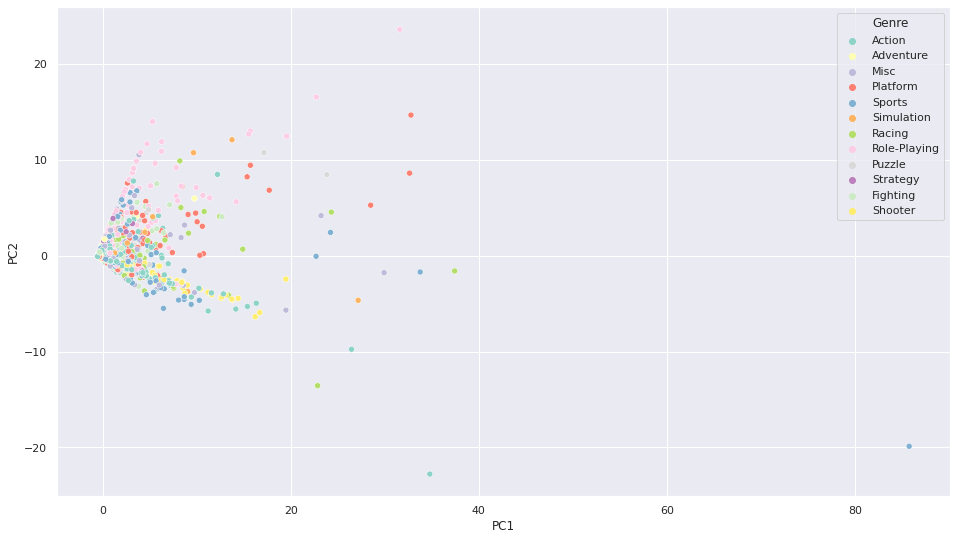

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue='Genre',palette = 'Set3')

여기서 눈에 띄도록 PC1에서 하나의 선을 이루는건 Shooter/Action이며 PC1과 PC2 전부 높은 수치를 가진 것은 Role-Playing 이다.

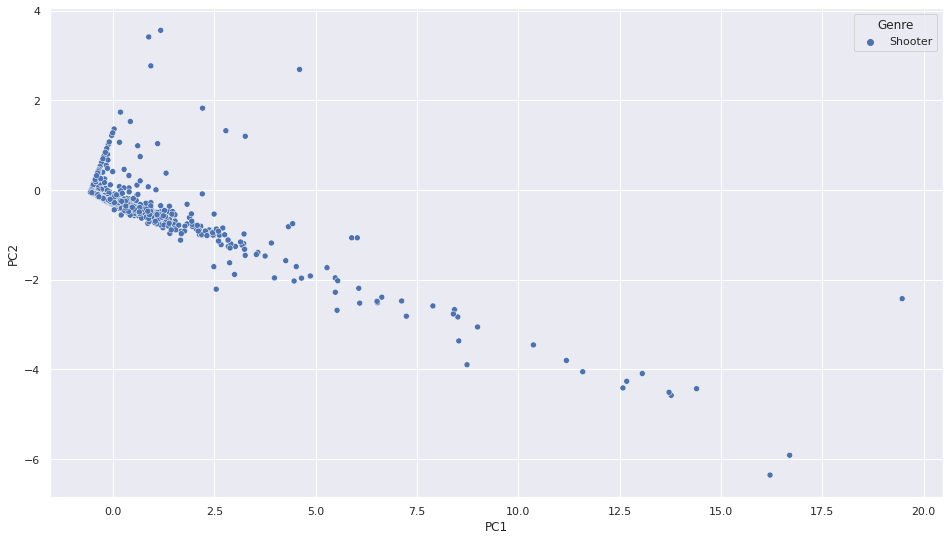

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue=df_pca[df_pca['Genre'] == 'Shooter']['Genre'])

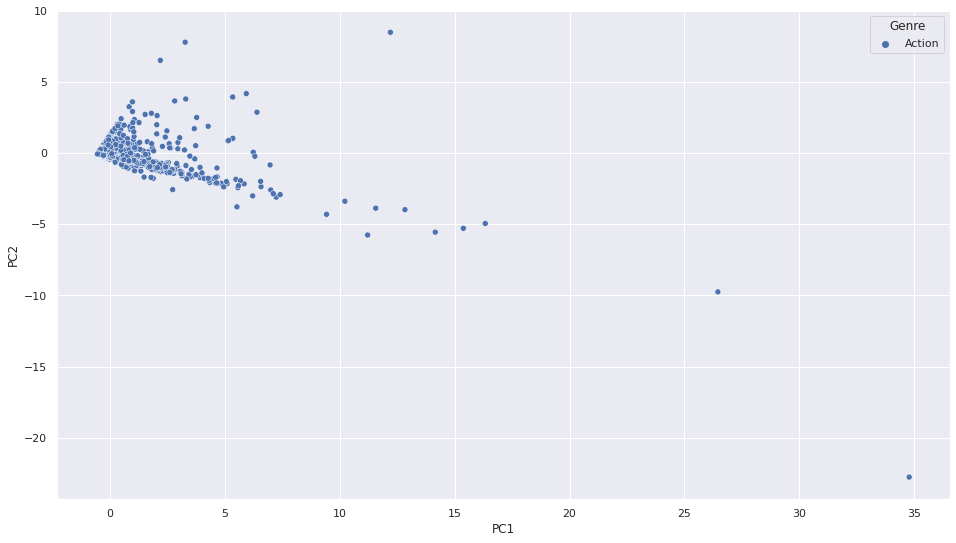

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue=df_pca[df_pca['Genre'] == 'Action']['Genre'])

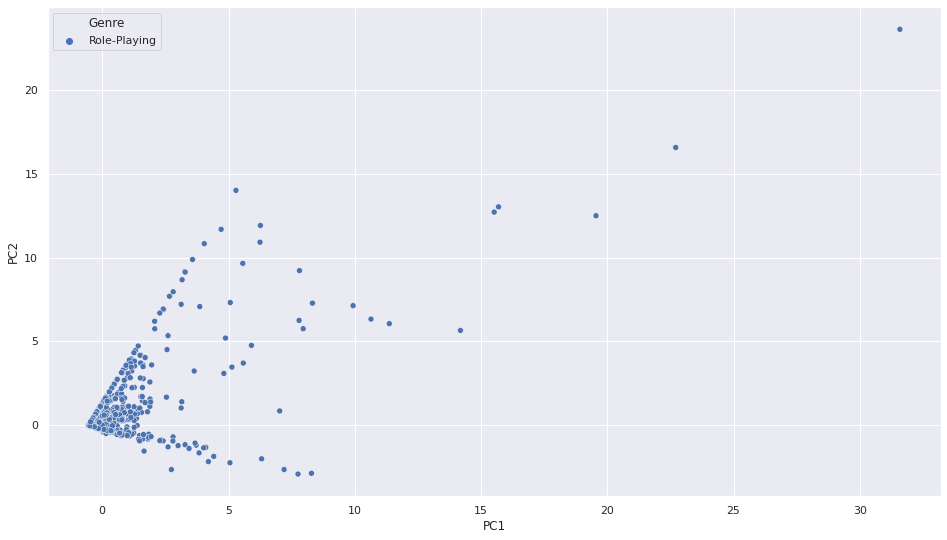

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue=df_pca[df_pca['Genre'] == 'Role-Playing']['Genre'])

Shooter, Action, Role-Playing은 전반적으로 높은 수치를 기록하는 것이 보인다.

그에 비해서 낮은 선호도를 가졌을 것이라고 판단되는 비주류의 장르인 Strategy는 아래처럼

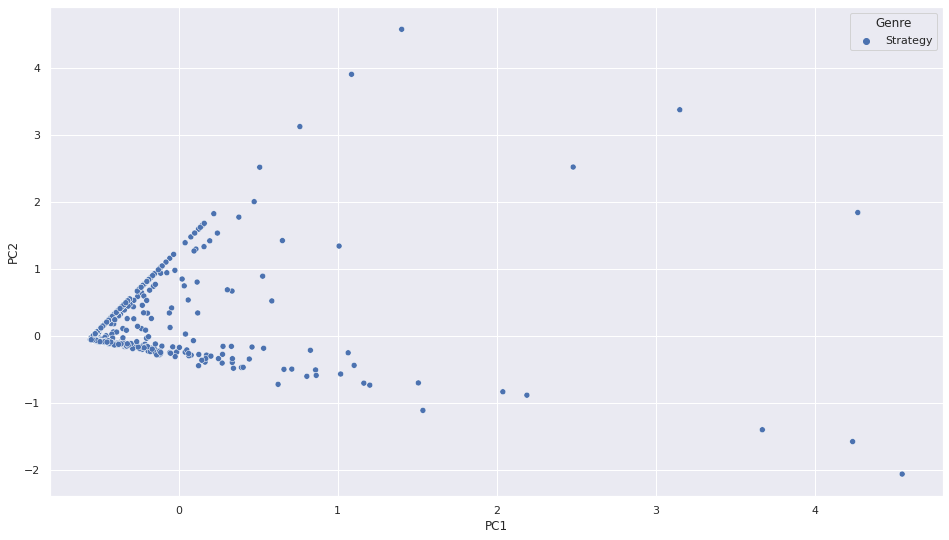

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(data=df_pca,x='PC1',y='PC2',hue=df_pca[df_pca['Genre'] == 'Strategy']['Genre'])

최대 PC1, 2가 약 0~1 정도에 불과할 정도로 낮은 선호도의 군집을 보인다.

In [ ]:
pca.explained_variance_ratio_

array([0.67331902, 0.18988961])

In [ ]:
sales = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','All_Sales']]
scaler = StandardScaler()

# StandardScaler 로 데이터 셋 변환 .fit( ) 과 .transform( ) 호출
scaler.fit(sales)
s = scaler.transform(sales)

# transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
s_df = pd.DataFrame(data=s, columns=sales.columns)
s_df['Year'] = df['Year']

In [ ]:
sse = {}

for k in range(1,10):
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(s_df)
  sse[k] = kmeans.inertia_

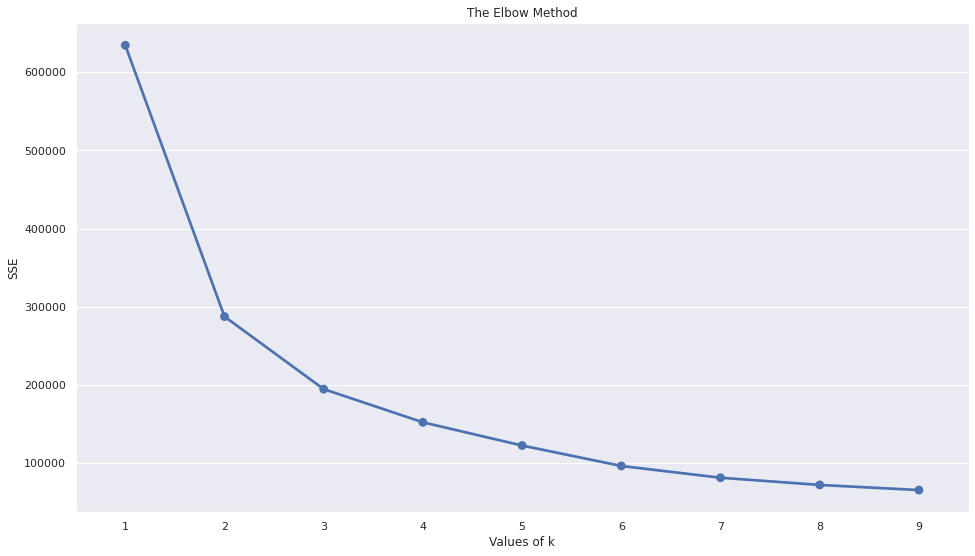

In [ ]:
plt.title('The Elbow Method')
plt.xlabel('Values of k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=69)
kmeans.fit(s_df)

# 고객별 클러스터 지정
labels = kmeans.labels_

s_df['cluster'] = labels

In [ ]:
s_df['Genre'] = df['Genre']
s_df['Platform'] = df['Platform']

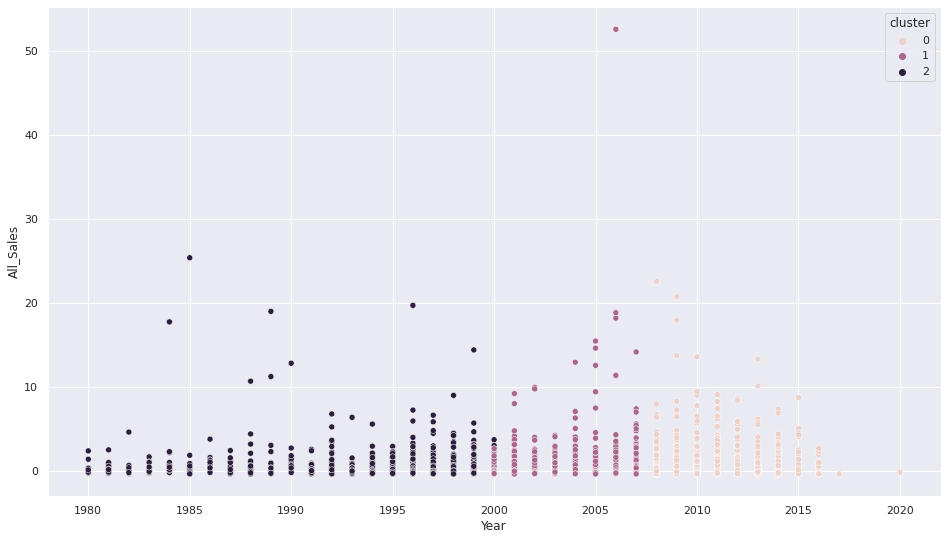

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.scatterplot(x=s_df['Year'], y=s_df['All_Sales'], hue=s_df['cluster'])

K-Means 클러스터링을 통하여 최근의 트렌드를 가진 장르일 경우에는 cluster값이 0이 나오도록 하였다.

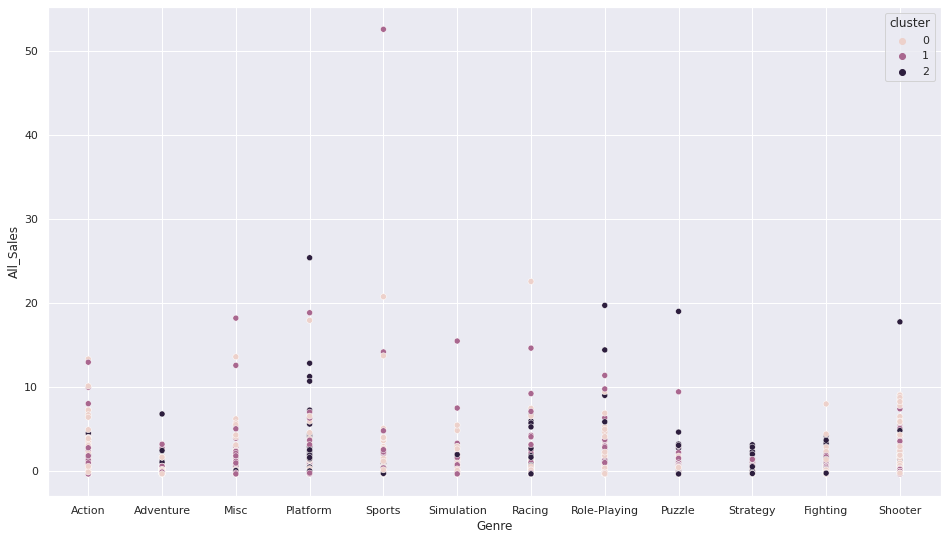

In [ ]:
sns.scatterplot(x=s_df['Genre'], y=s_df['All_Sales'], hue=s_df['cluster'])

In [ ]:
size = s_df[s_df['cluster'] == 0].groupby('Genre').size()


In [ ]:
size

Genre
Action          1924
Adventure        845
Fighting         306
Misc             978
Platform         240
Puzzle           258
Racing           398
Role-Playing     771
Shooter          569
Simulation       447
Sports           953
Strategy         282
dtype: int64

0이 최신, 1이 중간, 2가 고전

0에 가까울수록 최근의 트렌드에 해당한다


Action - 1926 / Misc - 978 / Sports - 953 으로 3개의 장르가 최근의 트렌드라고 볼 수 있다.



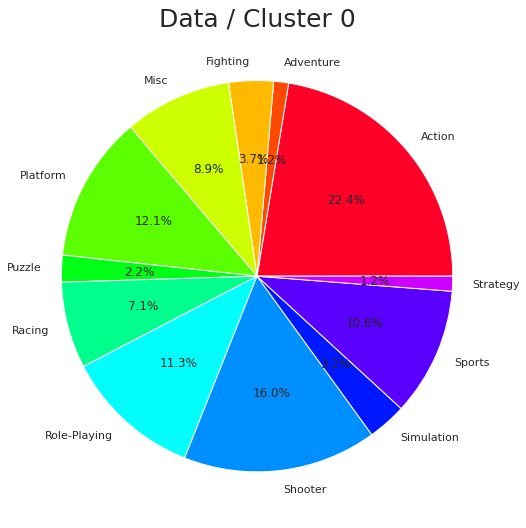

In [ ]:
NUM_COLORS = 12

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.pie(size, labels=size.index, autopct='%.1f%%')
plt.title('Data / Cluster 0',fontsize=25)
plt.show()

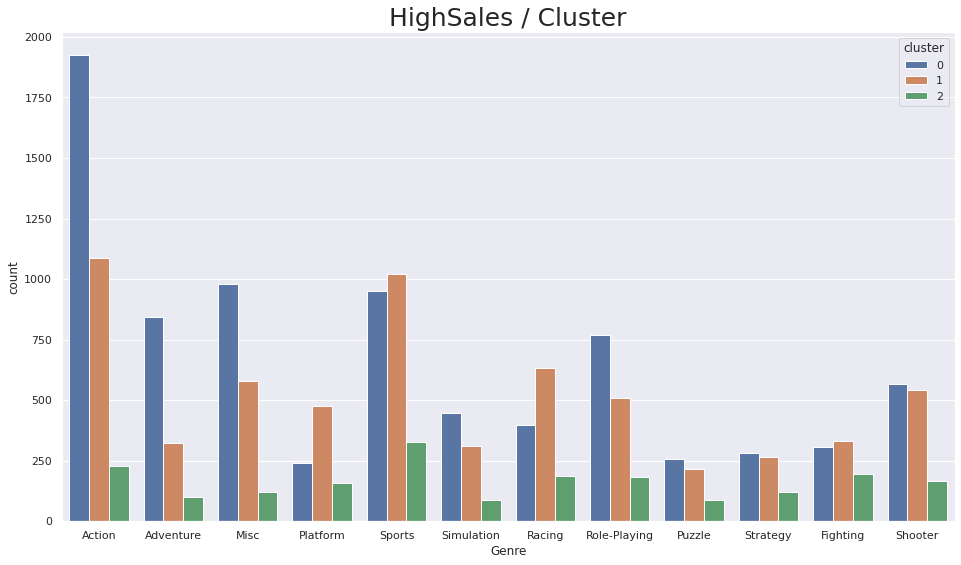

In [ ]:
plt.title('Sales / Cluster',fontsize=25)
sns.countplot(data=s_df, x="Genre", hue="cluster")

# **출고량이 높은 게임에 대한 분석 및 시각화**

In [ ]:
high_sales = s_df[s_df['All_Sales'] > np.percentile(s_df['All_Sales'], 97.5)]

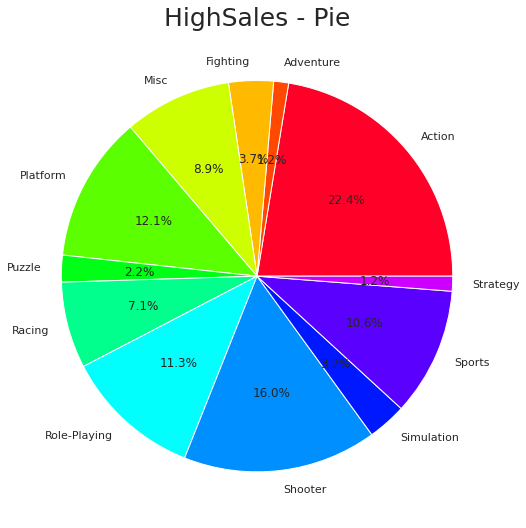

In [ ]:
size = high_sales.groupby('Genre').size()
NUM_COLORS = 12

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.pie(size, labels=size.index, autopct='%.1f%%')
plt.title('HighSales - Pie',fontsize=25)
plt.show()

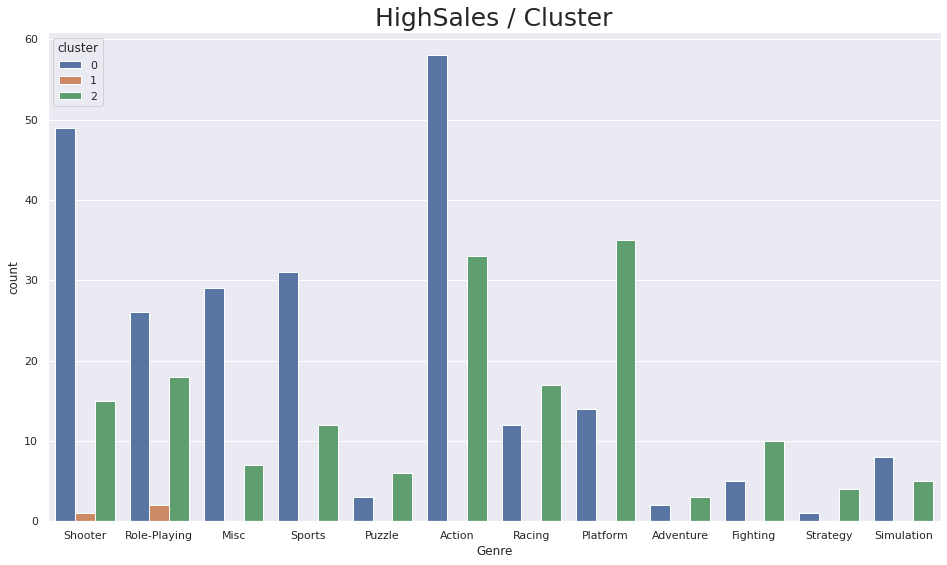

In [ ]:
plt.title('HighSales / Cluster',fontsize=25)
sns.countplot(data=high_sales, x="Genre", hue="cluster")

상위 2.5%의 출고량(판매량)을 가진 게임들을 장르별로 시각화했다.

이 경우 바로 눈에 띄게 보이는 것은 Action이며

cluster를 포함한 그래프로 보았을 때는 cluster가 0일 경우에는 다른 특성을 지닌다.



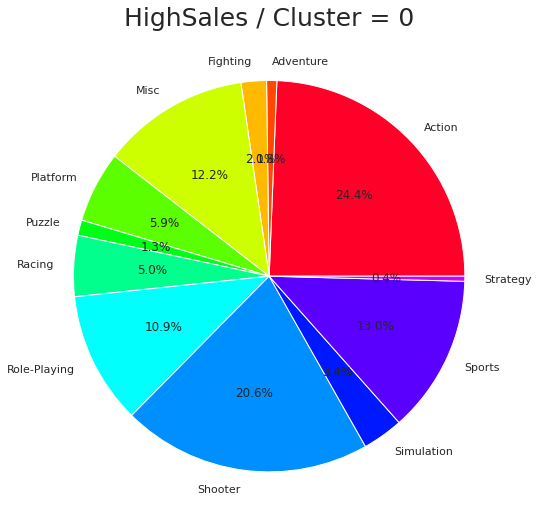

In [ ]:
size = high_sales[high_sales['cluster']==0].groupby('Genre').size()
NUM_COLORS = 12

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.pie(size, labels=size.index, autopct='%.1f%%')
plt.title('HighSales / Cluster = 0',fontsize=25)
plt.show()



즉, 최근 트렌드를 가진 장르이면서, 동시에 출고량이 높은 장르라는 것이다.

이제 세부적으로 상위권 게임들이 어떤 특징을 가졌는지 확인해볼 필요가 있다고 판단한다.

In [ ]:
high_sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales,Year,cluster,Genre,Platform
119,6.863774,4.392123,0.167228,4.490727,5.614907,2007.0,0,Shooter,Console
160,-0.079274,-0.014515,13.004220,-0.148857,2.507205,2000.0,2,Role-Playing,Console
189,2.924111,1.460922,-0.091452,1.696432,2.200272,2009.0,0,Shooter,Console
220,7.034006,5.906905,-0.253127,5.387010,6.222380,2011.0,0,Misc,Console
378,1.671687,4.588848,1.169613,2.803605,2.942028,2008.0,0,Sports,Console
...,...,...,...,...,...,...,...,...,...
16160,4.127897,4.470813,2.915702,3.119941,4.579006,2010.0,0,Platform,Console
16176,17.418179,13.598849,14.944320,11.660994,17.949798,2009.0,0,Platform,Console
16189,1.805441,2.070769,-0.188457,2.012767,1.829394,2004.0,2,Action,Console
16197,2.911951,0.693695,-0.091452,1.327374,1.899733,2008.0,0,Shooter,Console


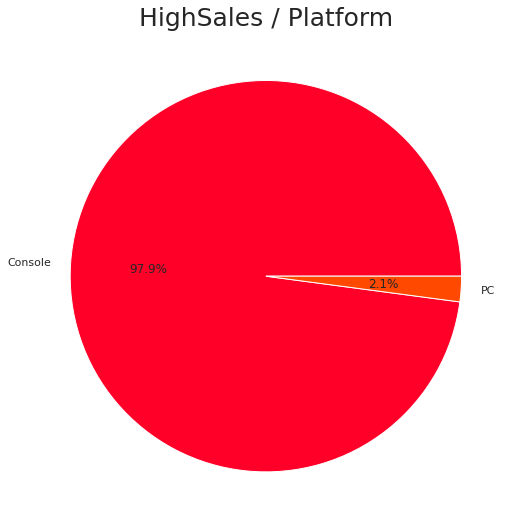

In [ ]:
size = high_sales[high_sales['cluster']==0].groupby('Platform').size()
NUM_COLORS = 12

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.pie(size, labels=size.index, autopct='%.1f%%')
plt.title('HighSales / Platform',fontsize=25)
plt.show()

In [ ]:
df.iloc[12341]

Name           Mario Kart Wii
Platform              Console
Year                     2008
Genre                  Racing
Publisher            Nintendo
NA_Sales           15850000.0
EU_Sales           12880000.0
JP_Sales            3790000.0
Other_Sales         3310000.0
All_Sales          35830000.0
Name: 12341, dtype: object

In [ ]:
df.iloc[3293]

Name           Wii Sports Resort
Platform                 Console
Year                        2009
Genre                     Sports
Publisher               Nintendo
NA_Sales              15750000.0
EU_Sales              11010000.0
JP_Sales               3280000.0
Other_Sales            2960000.0
All_Sales             33000000.0
Name: 3293, dtype: object

In [ ]:
df.iloc[16212]

Name           New Super Mario Bros. Wii
Platform                         Console
Year                                2009
Genre                           Platform
Publisher                       Nintendo
NA_Sales                      14590000.0
EU_Sales                       7060000.0
JP_Sales                       4700000.0
Other_Sales                    2260000.0
All_Sales                     28610000.0
Name: 16212, dtype: object

총 판매량이 가장 많은 상위 3개 게임은 모두 Platform이 Console 이다.

그런데, 한국 게임시장 특성상 콘솔 게임보다는 PC게임이 강세를 보인다.

이에 따라서 PC게임 중에서 상위권에 해당하는 게임들의 분석이 필요하다고 본다.

출처 : https://www.kocca.kr/kocca/bbs/view/B0000146/1846226.do?searchCnd=&searchWrd=&cateTp1=&cateTp2=&useAt=&menuNo=204154&categorys=0&subcate=0&cateCode=&type=&instNo=0&questionTp=&uf_Setting=&recovery=&option1=&option2=&year=&categoryCOM062=&categoryCOM063=&categoryCOM208=&categoryInst=&morePage=&delCode=0&qtp=&pageIndex=1

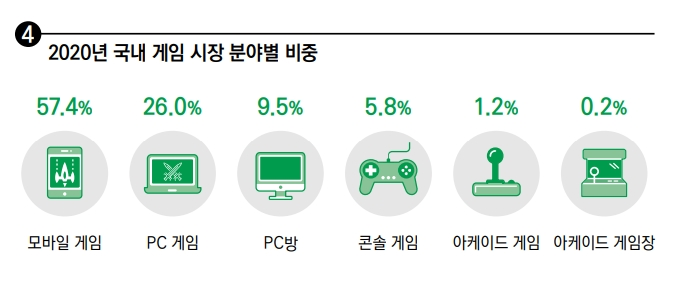

In [ ]:
PC_sales = high_sales[high_sales['Platform'] == 'PC']

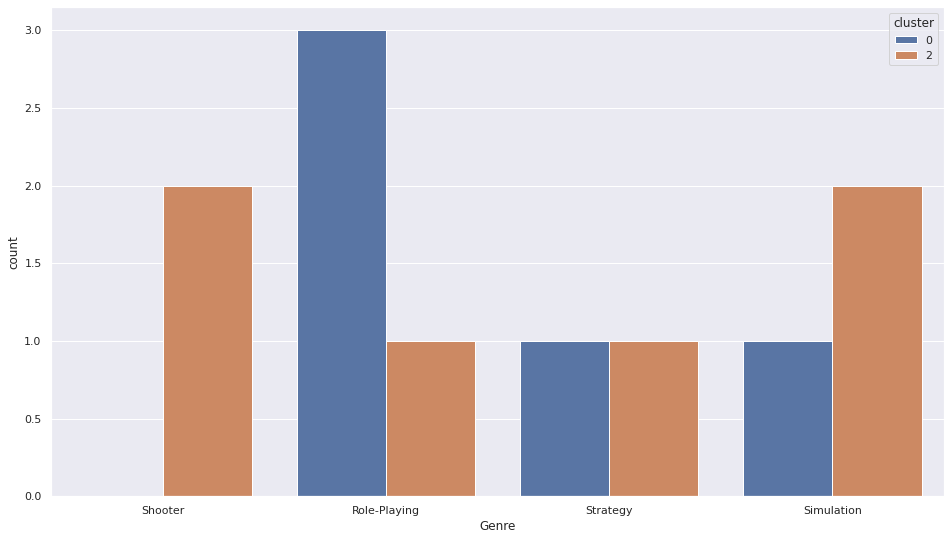

In [ ]:
sns.countplot(data=PC_sales, x="Genre", hue="cluster")

PC 게임에 한해서 판매량 상위권이면서 동시에 최신 트렌드(cluster = 0)인 장르는 [Role-Playing, Strategy와 Simulation]이다.


1차적으로 예측한 장르가 [Shooter, Role-Playing, Action] 였었다는 점과 다소 다른 부분이 있다.

이는 한국과 같은 PC게임 시장의 특수성이 있기 때문이라고 판단한다.

따라서 PC게임 시장에만 집중할 것인지, 글로벌 시장에도 수출할 것인지에 대한 계획에 따라서 다음 분기에 설계할 게임의 합리적인 장르는 바뀔 수가 있다.

우리는 한국 시장에 집중하며 글로벌 시장으로의 진출도 생각하는 게임을 설계하기 때문에 PC 게임의 데이터만으로 판단하지 않을 것이다.

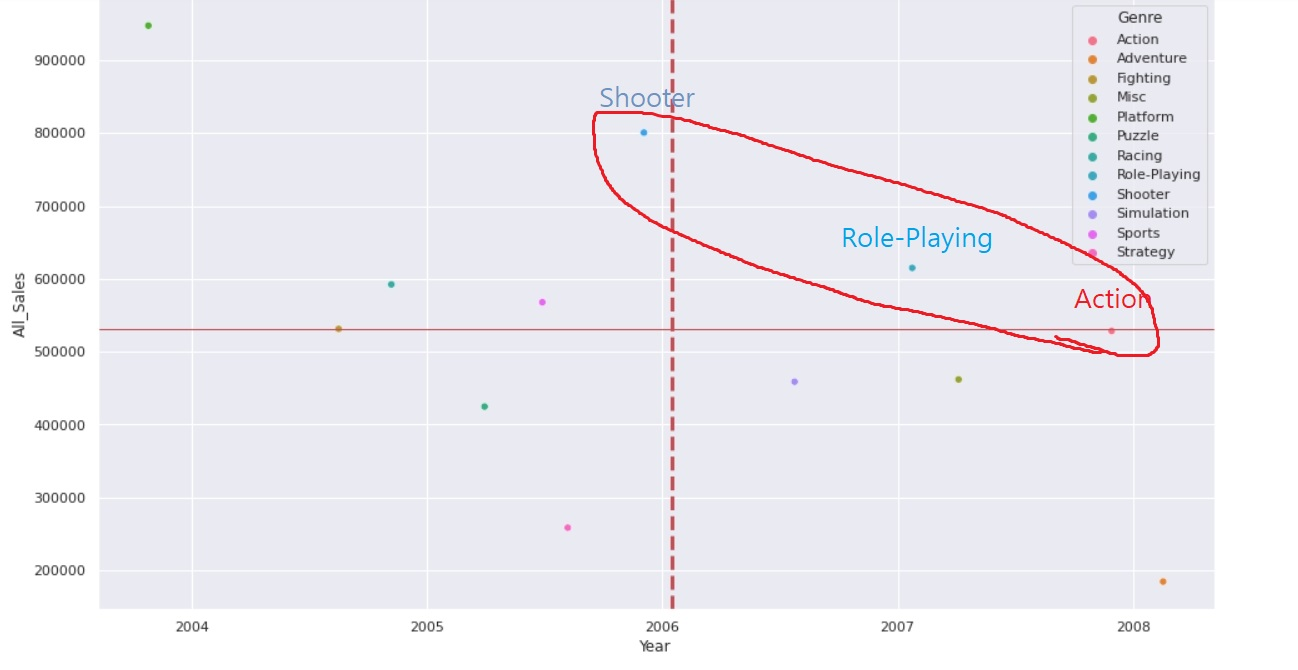

그러나, 공통적으로 [Role-Playing] 장르가 존재한다는 점에서 Role-Playing이 핵심이라고 판단할 수 있다. 또한 PC게임의 경우 Console 게임으로도 발매되는 경우나 그 반대의 상황도 있기 때문에 PC게임만을 놓고 본 데이터의 정확성을 입증하기가 어렵다.


최근에는 Platform 간의 경계선이 허물어지고 있는 추세이기 때문에 PC시장을 독립적으로 판단하기에는 무리가 있다고 본다.

이른바 "멀티플랫폼" 이라는 개념이 등장하는 중이다.


"하나의 게임을 PC와 모바일 기기, 콘솔 게임기 등에서 모두 즐길 수 있는 멀티플랫폼 게임이 대세로 자리 잡은 모습이다. 미국 E3, 일본 도쿄 게임쇼와 함께 세계 3대 게임 전시회로 불리는 독일 ‘게임스컴 2021’에도 이같은 경향이 강하게 나타났다."

출처 : https://biz.chosun.com/it-science/ict/2021/08/27/2O37MXCTEZE4ZNWDU4OTTDCY6I/

**이에 따라서 사후분석으로 장르 간의 평균 선호도에 유의미한 차이가 있는지 확인하는 Tukey's HSD를 사용하여 장르끼리의 차이를 알아본다.**

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

hsd = pairwise_tukeyhsd(df.All_Sales, df.Genre, alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,-344139.1712,0.001,-512493.0552,-175785.2873,True
Action,Fighting,2488.0979,0.9,-194759.3451,199735.5409,False
Action,Misc,-64866.4779,0.9,-217634.9162,87901.9604,False
Action,Platform,419744.6226,0.001,225940.4844,613548.7608,True
Action,Puzzle,-103379.5097,0.9,-334914.6905,128155.6711,False
Action,Racing,64042.4199,0.9,-106726.0537,234810.8935,False
Action,Role-Playing,86667.6568,0.8124,-73344.071,246679.3847,False
Action,Shooter,271888.4066,0.001,104102.6674,439674.1459,True
Action,Simulation,-68555.6869,0.9,-264780.9015,127669.5278,False
Action,Sports,39088.463,0.9,-99503.1694,177680.0955,False


Role-Playing은 Action과도 통계적으로 유의미한 차이가 없으며, Shooter와도 차이가 없다.

같은 집단이라고 판단할 수도 있는 장르이기에 복합적인 장르로 섞을 수 있을 것이라고 생각한다.

따라서, [Role-Playing]의 장르를 주로 하며 [Shooter, Action]이 들어가는 복합적인 장르의 게임이 다음 분기에서 설계하기에 좋을 것으로 예상된다.

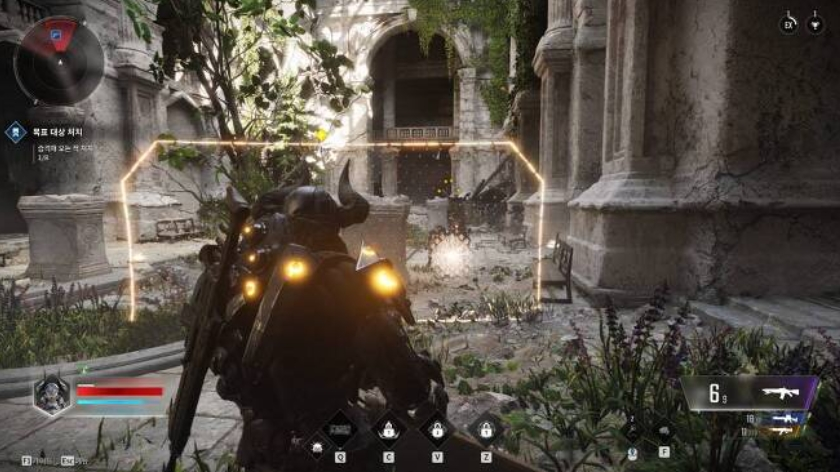

이러한 데이터 분석을 반영하듯이, 국내 대기업 N사에서 새로 개발한 게임인 "퍼스트 디센던트" 라는 게임은 위의 [Role-Playing] 과 [Shooter, Action]의 장르를 가진 게임이다.

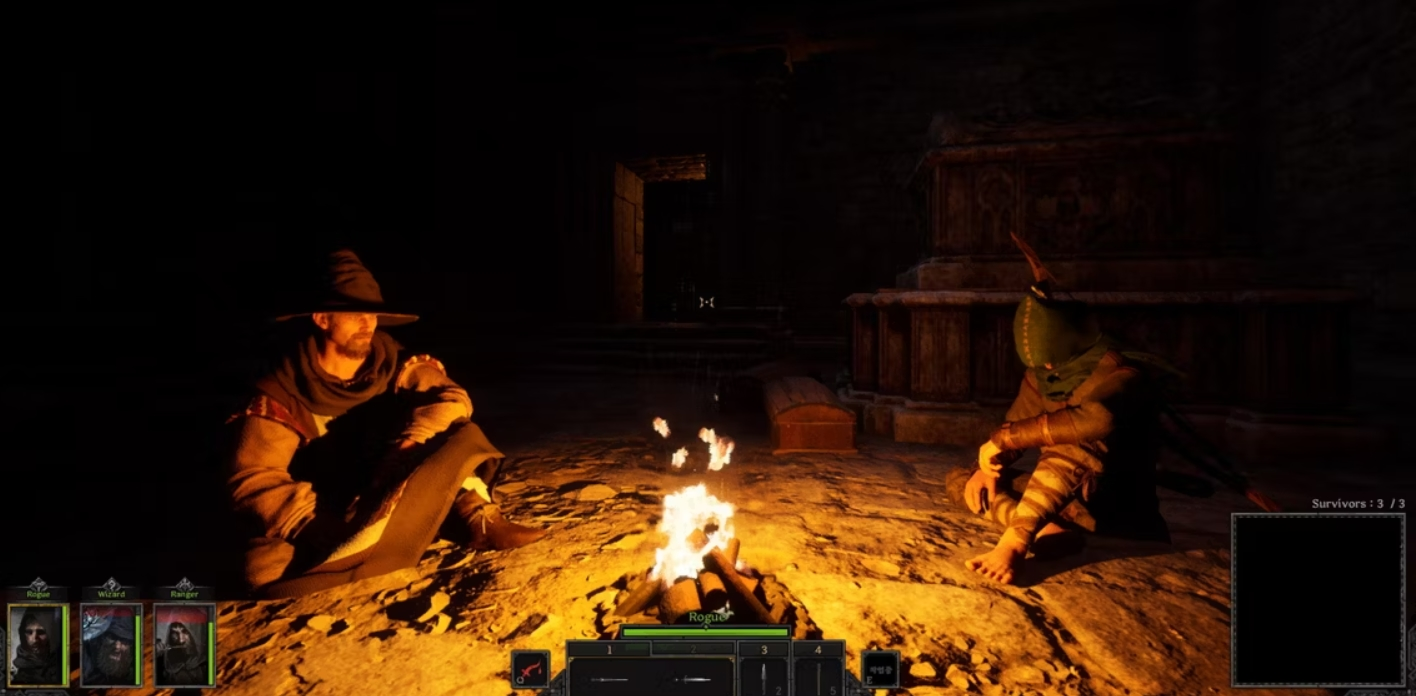

또한 국내 개발사에 개발중인 'Dark and Darker' 또한 이런 복합적인 장르를 가진 게임이며 최근의 트렌드가 Role-Playing을 중심으로 한 Action, Shooter 장르라고 생각해볼 수 있다.



결론적으로 다음 분기에 설계할 게임 장르로 적합한 것은 [Role-Playing]을 중심으로 한 [Action, Shooter] 장르라고 판단한다